In [1]:
# !git clone https://github.com/dariush-bahrami/character-tokenizer.git

In [2]:
# !pip install transformers

In [3]:
import string
import sys
sys.path.append("./character-tokenizer")
from charactertokenizer import CharacterTokenizer

chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"
model_max_length = 64
tokenizer = CharacterTokenizer(chars, model_max_length)

In [4]:
example = "Привет"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 39, 42, 26, 12, 18, 46, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


Задание: обучите модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers. Датасет для обучения можно взять отсюда: https://github.com/Koziev/NLP_Datasets/blob/master/Stress/all_accents.zip

1. Напишите класс для Dataset/Dataloder и азбейте данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробуйте несколько моделей: Bert, Albert, Deberta. (3 балла)
Пример конфигурации для deberta: https://huggingface.co/IlyaGusev/ru-word-stress-transformer/blob/main/config.json

In [5]:
# !wget https://github.com/Koziev/NLP_Datasets/raw/master/Stress/all_accents.zip
# !unzip -u all_accents.zip -d ./

In [6]:
import numpy as np
import pandas as pd
from transformers import BertConfig, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, AlbertForSequenceClassification,\
DebertaV2ForTokenClassification, PretrainedConfig, DebertaV2ForSequenceClassification, DebertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import random
import time
import datetime
import gc
from matplotlib import pyplot as plt

SEED = int(1e9+7e7+17)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
pin_memory:bool=True
batch_size:int=128
workers:int=16
epochs:int=4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:",torch.cuda.get_device_name(device.index) if device.type=="cuda" else device.type)

Device: Tesla V100-SXM2-32GB


In [8]:
df = pd.read_csv('all_accents.tsv', sep='\t', header=None)

def getLabel(s, vowels='аАуУоОыЫиИэЭяЯюЮёЁеЕ'):
    idx = s.find('^')
    if(idx==-1 and sum([v in vowels for v in s])==1):
        idx = max([s.find(v) for v in vowels])
    return idx
labels = [getLabel(s) for s in df[1]]
sentences = df[0]

In [40]:
df.head()

,0,1
0,-де,-д^е
1,-ка,-к^а
2,-либо,-л^ибо
3,-нибудь,-ниб^удь
4,-с,-с


In [9]:
max_len = 0

# For every sentence...
for sent in tqdm(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

100%|██████████| 1680535/1680535 [01:46<00:00, 15792.62it/s]

Max sentence length:  58


In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
labels_ = []
MAX_LENGTH = max_len
# For every sentence...
for sent, lab in tqdm(zip(sentences, labels), total=len(labels)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    if(lab==-1): continue
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    labels_.append(lab)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/1680535 [00:00<?, ?it/s]/home/vvkakurin/.conda/envs/608/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1680535/1680535 [03:39<00:00, 7661.22it/s] 


Original:  -де
Token IDs: tensor([ 0,  6, 16, 18,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4])


In [11]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

840,046 training samples
840,047 validation samples


In [12]:
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            pin_memory=pin_memory,
            num_workers=workers,
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            pin_memory=pin_memory,
            num_workers=workers,
        )

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [51]:
def test_model(model, length:int=100):
    df = pd.read_csv('all_accents.tsv', sep='\t', header=None)
    labels = [getLabel(s) for s in df[1]]
    sentences = df[0]
    
    idx = list(range(len(labels)))
    np.random.seed(1)
    np.random.shuffle(idx)
    idx = idx[:length]
    labels = [labels[i] for i in idx]
    sentences = [sentences[i] for i in idx]
    
    input_sentences = []
    input_ids = []
    attention_masks = []
    labels_ = []
    
    for sent, lab in zip(sentences, labels):
        if(lab==-1): continue
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                            truncation=True,
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        input_sentences.append(sent)
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        labels_.append(lab)

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_)
    
    b_input_ids = input_ids.to(device, non_blocking=True)
    b_input_mask = attention_masks.to(device, non_blocking=True)
    b_labels = labels.to(device, non_blocking=True)
        
    with torch.no_grad():
        output = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
    print('Loss:', output.loss.item())

    logits = output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    print('Accuracy:', flat_accuracy(logits, label_ids))
    
    am = logits.argmax(axis=1)
    ans = [s[:i] + '^' + s[i:] for s,i in zip(input_sentences,am)]
    return ans

## Bert

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased",
    num_labels = max_len, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.to(device);

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/home/vvkakurin/.conda/envs/608/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [17]:
training_stats = []
losses_train = []
losses_val = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    # print("")
    # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    # print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    tq = tqdm(train_dataloader)
    for step, batch in enumerate(tq):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad(set_to_none=True)        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += output.loss.item()
        losses_train.append(output.loss.item())
        tq.set_postfix({'state':'train',
                        'loss':losses_train[-1],
                        'mean':np.mean(losses_train[-100:])})

        # Perform a backward pass to calculate the gradients.
        output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # torch.cuda.empty_cache()
    # gc.collect()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    tq = tqdm(validation_dataloader)
    for batch in tq:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += output.loss.item()
        losses_val.append(output.loss.item())
        tq.set_postfix({'state':'val',
                        'loss':losses_val[-1],
                        'mean':np.mean(losses_val[-100:])})

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # torch.cuda.empty_cache()
    # gc.collect()

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

100%|██████████| 6563/6563 [14:06<00:00,  7.76it/s, state=val, loss=0.5, mean=0.488]  


  Accuracy: 0.81
  Validation Loss: 0.48
  Validation took: 0:14:06


100%|██████████| 6563/6563 [14:08<00:00,  7.73it/s, state=val, loss=0.294, mean=0.381]


  Accuracy: 0.85
  Validation Loss: 0.37
  Validation took: 0:14:09


100%|██████████| 6563/6563 [15:27<00:00,  7.08it/s, state=val, loss=0.254, mean=0.322]


  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:15:28


100%|██████████| 6563/6563 [14:47<00:00,  7.40it/s, state=val, loss=0.211, mean=0.3]  

  Accuracy: 0.88
  Validation Loss: 0.30
  Validation took: 0:14:47

Training complete!


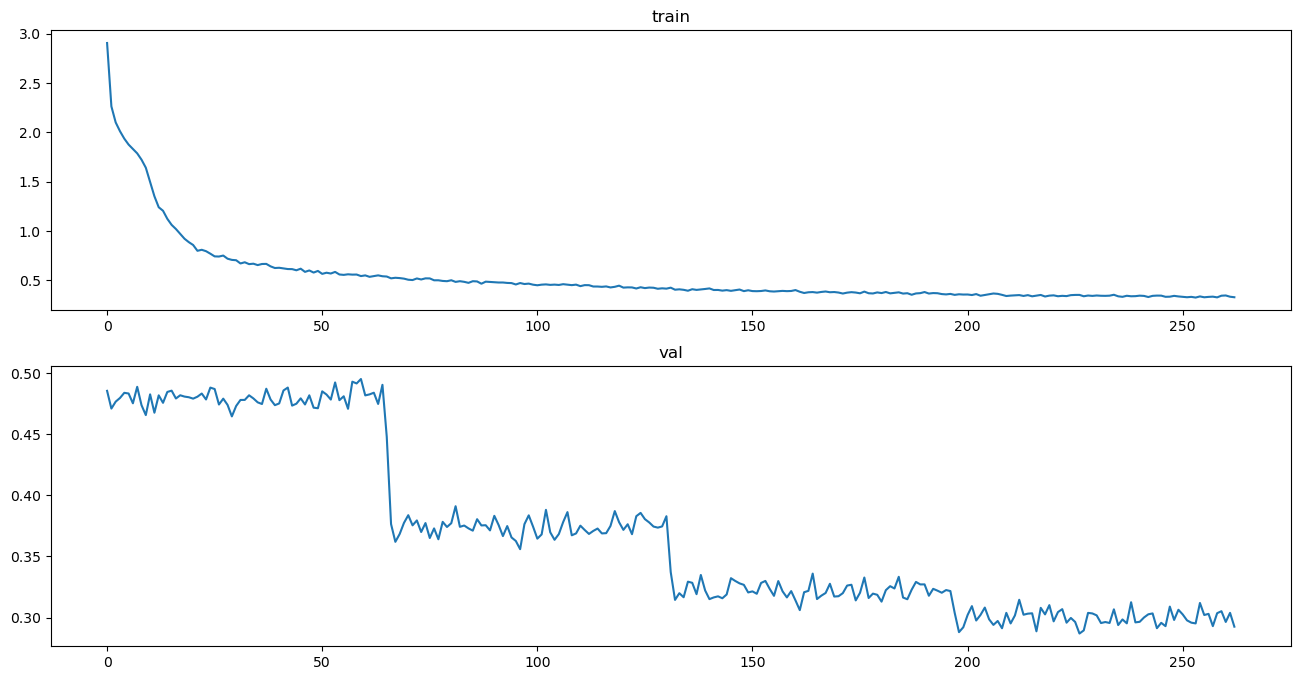

In [18]:
rolling_train = [np.mean(losses_train[i:i+100]) for i in range(0, len(losses_train), 100)]
rolling_val = [np.mean(losses_val[i:i+100]) for i in range(0, len(losses_val), 100)]
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(rolling_train)
plt.title('train')
plt.subplot(2,1,2)
plt.plot(rolling_val)
plt.title('val');

In [52]:
print(test_model(model))

/home/vvkakurin/.conda/envs/608/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Loss: 0.21429838240146637
Accuracy: 0.91
['ап^ексе', 'зал^япывало', 'г^оночными', 'сп^ектру', 'застр^ачиваюсь', 'бутурл^инских', 'стар^ательнейшие', 'вывор^ачиваются', 'витам^инным', 'тр^онусь', 'пох^улит', 'сах^об', 'электробытов^ой', 'криминализ^ируюсь', 'рекр^утской', 'г^оши', 'комфорт-кл^асс', 'пустов^атости', 'вак^уумному', 'втрамб^овывающийся', 'изв^озные', 'артикул^ируешься', 'разгримиров^авший', 'м^ерзко', 'сарм^атов', 'подп^итывавшийся', 'изр^анило', 'муравь^иные', 'усек^ающею', 'алкаш^а', 'перепл^атам', 'к^аемочного', 'неш^уточное', 'ашкен^азский', 'сар^аус', 'разоблач^аемом', 'белом^ордыми', 'от^арович', 'каб^олками', 'взим^ающей', 'огруб^ела', 'дав^ыдкину', 'п^озванными', 'запомин^аемом', 'п^ылит', 'пескар^ях', 'тираж^ировалось', 'марцип^ана', 'вырезн^ыми', 'нал^ичествующими', 'поплю^ю', 'отпр^авившейся', 'шп^ак', 'напис^аю', 'согр^етым', 'крестоцв^етной', 'кривон^огой', 'в^ыученном', 'к^онченом', 'зубор^езные', 'соп^ерничку', 'захорон^ившихся', 'в^ыхаркнем', 'брак^ованном'

## Albert

In [19]:
torch.cuda.empty_cache()
gc.collect()

5682

In [20]:
albert = AlbertForSequenceClassification.from_pretrained("flax-community/alberti-bert-base-multilingual-cased",
    num_labels = max_len, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
albert.to(device);

You are using a model of type bert to instantiate a model of type albert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at flax-community/alberti-bert-base-multilingual-cased were not used when initializing AlbertForSequenceClassification: ['bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.8.intermediate.dense.bias', 'bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.9.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.output.LayerNorm.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.4.attention.output.LayerNorm.bias', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.sel

In [21]:
albert_optimizer = AdamW(albert.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
albert_scheduler = get_linear_schedule_with_warmup(albert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [23]:
albert_training_stats = []
albert_losses_train = []
albert_losses_val = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    # print("")
    # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    # print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    albert.train()

    # For each batch of training data...
    tq = tqdm(train_dataloader)
    for step, batch in enumerate(tq):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        albert.zero_grad(set_to_none=True)        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = albert(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += output.loss.item()
        albert_losses_train.append(output.loss.item())
        tq.set_postfix({'state':'train',
                        'loss':albert_losses_train[-1],
                        'mean':np.mean(albert_losses_train[-100:])})

        # Perform a backward pass to calculate the gradients.
        output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(albert.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        albert_optimizer.step()

        # Update the learning rate.
        albert_scheduler.step()

    # torch.cuda.empty_cache()
    # gc.collect()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    albert.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    tq = tqdm(validation_dataloader)
    for batch in tq:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = albert(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += output.loss.item()
        albert_losses_val.append(output.loss.item())
        tq.set_postfix({'state':'val',
                        'loss':albert_losses_val[-1],
                        'mean':np.mean(albert_losses_val[-100:])})

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # torch.cuda.empty_cache()
    # gc.collect()

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    albert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

100%|██████████| 6563/6563 [14:43<00:00,  7.42it/s, state=val, loss=0.64, mean=0.602] 


  Accuracy: 0.76
  Validation Loss: 0.60
  Validation took: 0:14:44


100%|██████████| 6563/6563 [14:35<00:00,  7.49it/s, state=val, loss=0.526, mean=0.504]


  Accuracy: 0.80
  Validation Loss: 0.49
  Validation took: 0:14:36


100%|██████████| 6563/6563 [14:58<00:00,  7.31it/s, state=val, loss=0.479, mean=0.453]


  Accuracy: 0.82
  Validation Loss: 0.45
  Validation took: 0:14:58


100%|██████████| 6563/6563 [14:33<00:00,  7.52it/s, state=val, loss=0.433, mean=0.43] 

  Accuracy: 0.83
  Validation Loss: 0.42
  Validation took: 0:14:33

Training complete!


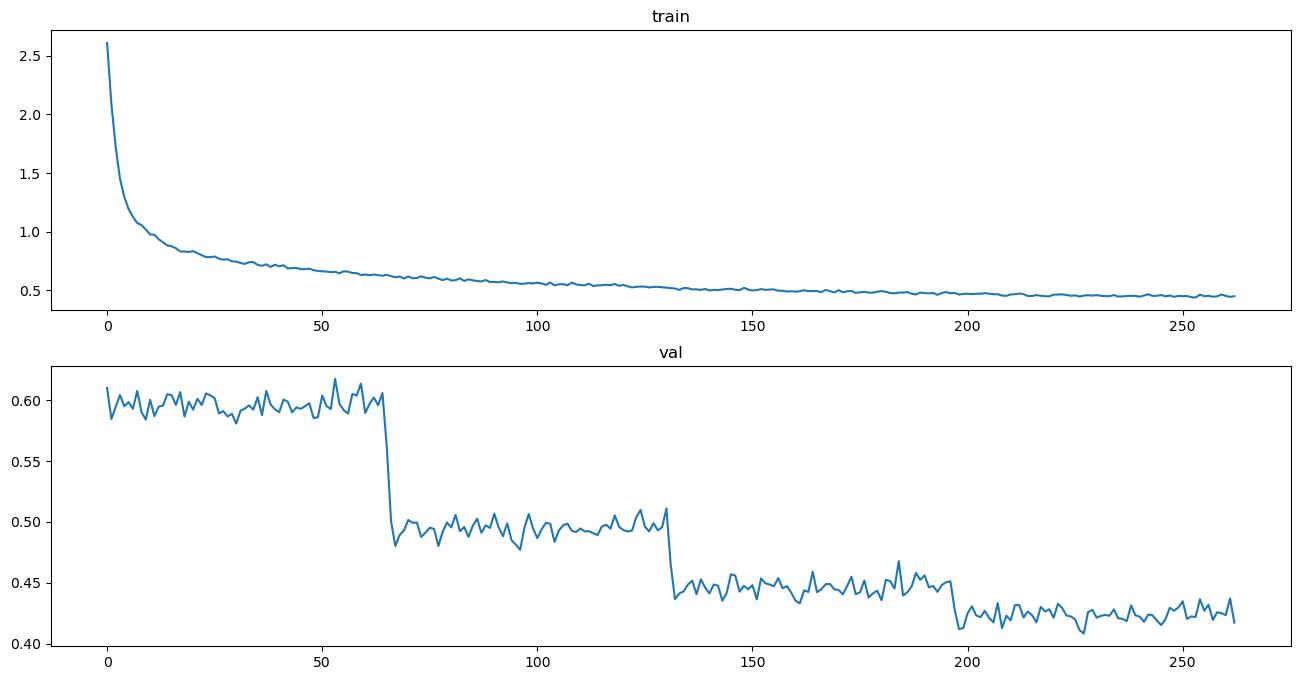

In [29]:
albert_rolling_train = [np.mean(albert_losses_train[i:i+100]) for i in range(0, len(albert_losses_train), 100)]
albert_rolling_val = [np.mean(albert_losses_val[i:i+100]) for i in range(0, len(albert_losses_val), 100)]
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(albert_rolling_train)
plt.title('train')
plt.subplot(2,1,2)
plt.plot(albert_rolling_val)
plt.title('val');

In [53]:
print(test_model(albert))

/home/vvkakurin/.conda/envs/608/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Loss: 0.4038691222667694
Accuracy: 0.88
['ап^ексе', 'зал^япывало', 'г^оночными', 'сп^ектру', 'застр^ачиваюсь', 'бутурл^инских', 'стар^ательнейшие', 'вывор^ачиваются', 'витам^инным', 'тр^онусь', 'похул^ит', 'сах^об', 'электроб^ытовой', 'криминализ^ируюсь', 'рекр^утской', 'г^оши', 'комфорт-кл^асс', 'пустов^атости', 'ваку^умному', 'втрамб^овывающийся', 'изв^озные', 'артикул^ируешься', 'разгрим^ировавший', 'м^ерзко', 'сарм^атов', 'подп^итывавшийся', 'изран^ило', 'муравь^иные', 'усек^ающею', 'алк^аша', 'перепл^атам', 'к^аемочного', 'неш^уточное', 'ашкен^азский', 'сар^аус', 'разоблач^аемом', 'белом^ордыми', 'от^арович', 'каб^олками', 'взим^ающей', 'огруб^ела', 'дав^ыдкину', 'п^озванными', 'запомин^аемом', 'пыл^ит', 'песк^арях', 'тираж^ировалось', 'марцип^ана', 'в^ырезными', 'нал^ичествующими', 'поплю^ю', 'отпр^авившейся', 'шп^ак', 'напис^аю', 'согр^етым', 'крестоцв^етной', 'кривон^огой', 'в^ыученном', 'к^онченом', 'зубор^езные', 'соп^ерничку', 'захорон^ившихся', 'в^ыхаркнем', 'брак^ованном',

## Deberta

In [24]:
torch.cuda.empty_cache()
gc.collect()

20

In [25]:
deberta = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base",
    num_labels = max_len, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
deberta.to(device);

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

In [26]:
deberta_optimizer = AdamW(deberta.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [27]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
deberta_scheduler = get_linear_schedule_with_warmup(deberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
deberta_training_stats = []
deberta_losses_train = []
deberta_losses_val = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    # print("")
    # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    # print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    deberta.train()

    # For each batch of training data...
    tq = tqdm(train_dataloader)
    for step, batch in enumerate(tq):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        deberta.zero_grad(set_to_none=True)        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = deberta(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += output.loss.item()
        deberta_losses_train.append(output.loss.item())
        tq.set_postfix({'state':'train',
                        'loss':deberta_losses_train[-1],
                        'mean':np.mean(deberta_losses_train[-100:])})

        # Perform a backward pass to calculate the gradients.
        output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(deberta.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        deberta_optimizer.step()

        # Update the learning rate.
        deberta_scheduler.step()

    # torch.cuda.empty_cache()
    # gc.collect()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    deberta.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    tq = tqdm(validation_dataloader)
    for batch in tq:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device, non_blocking=True)
        b_input_mask = batch[1].to(device, non_blocking=True)
        b_labels = batch[2].to(device, non_blocking=True)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = deberta(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += output.loss.item()
        deberta_losses_val.append(output.loss.item())
        tq.set_postfix({'state':'val',
                        'loss':deberta_losses_val[-1],
                        'mean':np.mean(deberta_losses_val[-100:])})

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # torch.cuda.empty_cache()
    # gc.collect()

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    deberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

100%|██████████| 6563/6563 [17:04<00:00,  6.41it/s, state=val, loss=0.356, mean=0.455]  


  Accuracy: 0.84
  Validation Loss: 0.45
  Validation took: 0:17:05


100%|██████████| 6563/6563 [17:05<00:00,  6.40it/s, state=val, loss=0.235, mean=0.335]  


  Accuracy: 0.88
  Validation Loss: 0.33
  Validation took: 0:17:06


100%|██████████| 6563/6563 [17:56<00:00,  6.10it/s, state=val, loss=0.223, mean=0.285]


  Accuracy: 0.89
  Validation Loss: 0.29
  Validation took: 0:17:56


100%|██████████| 6563/6563 [15:35<00:00,  7.02it/s, state=val, loss=0.206, mean=0.269] 

  Accuracy: 0.90
  Validation Loss: 0.27
  Validation took: 0:15:35

Training complete!


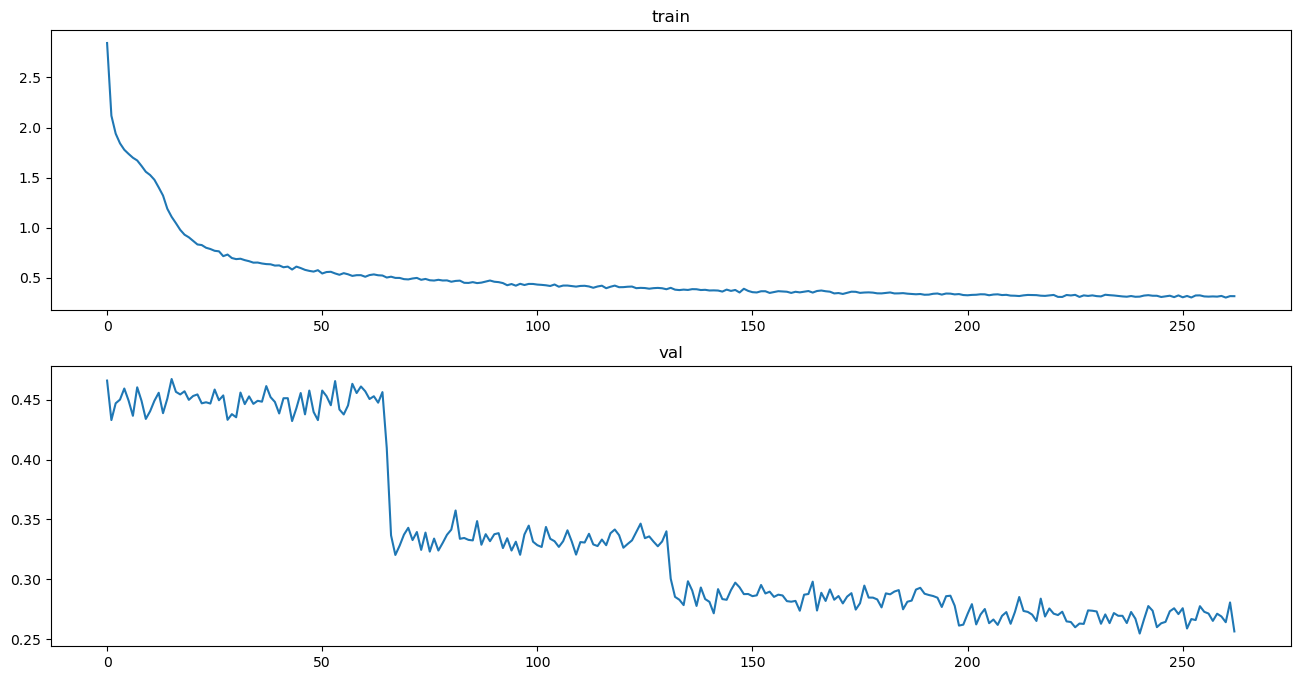

In [30]:
deberta_rolling_train = [np.mean(deberta_losses_train[i:i+100]) for i in range(0, len(deberta_losses_train), 100)]
deberta_rolling_val = [np.mean(deberta_losses_val[i:i+100]) for i in range(0, len(deberta_losses_val), 100)]
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(deberta_rolling_train)
plt.title('train')
plt.subplot(2,1,2)
plt.plot(deberta_rolling_val)
plt.title('val');

In [54]:
print(test_model(deberta))

/home/vvkakurin/.conda/envs/608/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Loss: 0.21440726518630981
Accuracy: 0.89
['ап^ексе', 'зал^япывало', 'г^оночными', 'сп^ектру', 'застр^ачиваюсь', 'бутурл^инских', 'стар^ательнейшие', 'вывор^ачиваются', 'витам^инным', 'тр^онусь', 'похул^ит', 'с^ахоб', 'электробытов^ой', 'криминализ^ируюсь', 'рекр^утской', 'г^оши', 'комфорт-кл^асс', 'пустов^атости', 'ваку^умному', 'втрамб^овывающийся', 'изв^озные', 'артикул^ируешься', 'разгримиров^авший', 'м^ерзко', 'сарм^атов', 'подп^итывавшийся', 'изран^ило', 'муравь^иные', 'усек^ающею', 'алк^аша', 'перепл^атам', 'к^аемочного', 'неш^уточное', 'ашкен^азский', 'сар^аус', 'разоблач^аемом', 'белом^ордыми', 'от^арович', 'каб^олками', 'взим^ающей', 'огруб^ела', 'дав^ыдкину', 'п^озванными', 'запомин^аемом', 'пыл^ит', 'пескар^ях', 'тираж^ировалось', 'марцип^ана', 'вырезн^ыми', 'нал^ичествующими', 'поплю^ю', 'отпр^авившейся', 'шп^ак', 'напис^аю', 'согр^етым', 'крестоцв^етной', 'кривон^огой', 'в^ыученном', 'к^онченом', 'зубор^езные', 'соп^ерничку', 'захорон^ившихся', 'в^ыхаркнем', 'брак^ованном'